<h1><center><b>Image Recognition Using Keras</b></center></h1>

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this Notebook, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We will apply Keras API for the image classification.

## Loading Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm.notebook import tqdm

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
K.clear_session()

## Load Data

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


Forming feature and label datasets and deleting train to release memory.

In [5]:
X = train.drop('label',axis=1)
Y = train['label']
del train

## Preprocessing

### Checking class imbalance

In [6]:
#checking for class imbalance
Y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Since all the label contains around 4K number of images therefore no class imbalance is present.

### Checking missing values

In [7]:
X.isnull().any().unique()

array([False])

In [8]:
test.isnull().any().unique()

array([False])

There is no missing value in the dataset or no presence of any corrupted image. So, we can move further.

### Normalization and reshaping the pixel values

We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converge faster on [0..1] data than on [0..255].

In [9]:
X = X / 255.0
test = test / 255.0

Train and test images (28px x 28px) has been stock into pandas Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [10]:
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [11]:
print(X.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


### Label encoding of target values

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [12]:
Y = to_categorical(Y, num_classes=10)

In [13]:
print(Y.shape)

(42000, 10)


### Split train and val set

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use **stratify = True** option in train_test_split function 

In [14]:
#set random seed
random_seed = 2

In [15]:
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.1,random_state=random_seed)

In [16]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)


### Visualizing the images

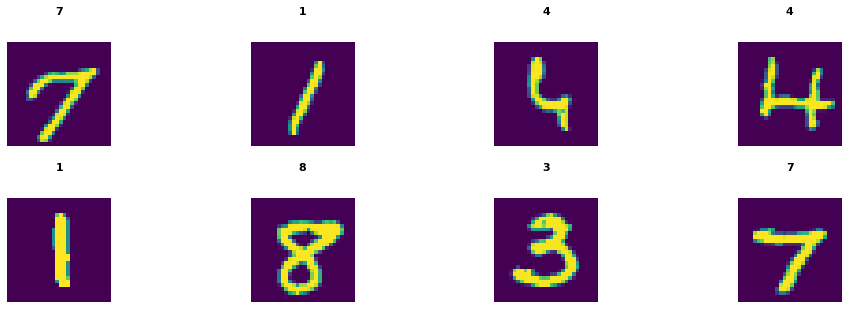

In [17]:
import random
ls = random.sample(range(1,37000),8)
plt.figure(figsize=[16,22])
idx=1
for i in ls:
    ax = plt.subplot(8,4,idx)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    ax.imshow(x_train[i][:,:,0])
    plt.axis('off')
    for j in range(10):
        if(y_train[i][j]==1):
            number = j
            break
    plt.title(number,size=11,y=1.2,fontweight='bold')
    idx += 1

## Building Model

### Model architecture

I am building a CNN network structure in Keras to classify the images, 

In [18]:
def NumClassifyModel(input_shape=(28,28,1), classes = 10):
    """
    Implementation of Model architechture - 
    Conv2D->BatchNormalization->Relu->Conv2D->BatchNormalization->Relu->MaxPooling2D->Dropout->Conv2D->BatchNormalization->
    Relu->Conv2D->BatchNormalization->Relu->MaxPooling2D->Dropout->Flatten->Dense->Dropout->Softmax
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    #input layer
    x_input = Input(input_shape)
    
    #stage 1 convulation layer
    x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', name = 'conv1', kernel_initializer = glorot_uniform(seed=2))(x_input)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    
    #stage 2 convulation layer
    x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', name = 'conv2', kernel_initializer = glorot_uniform(seed=2))(x)
    x = BatchNormalization(axis=3, name='bn_conv2')(x)
    x = Activation('relu')(x)
    
    #maxpooling layer with dropout
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    #stage 3 convulation layer
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', name = 'conv3', kernel_initializer = glorot_uniform(seed=2))(x)
    x = BatchNormalization(axis=3, name='bn_conv3')(x)
    x = Activation('relu')(x)
    
    #stage 4 convulation layer
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', name = 'conv4', kernel_initializer = glorot_uniform(seed=2))(x)
    x = BatchNormalization(axis=3, name='bn_conv4')(x)
    x = Activation('relu')(x)
    
    #maxpooling layer
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(0.25)(x)
    
    #fully connected networks with softmax output
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=2))(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='fc'+ str(classes), kernel_initializer = glorot_uniform(seed=2))(x)
    
    #keras instance of model
    model = Model(inputs=x_input, outputs=x, name='NumClassifyModel')
    
    return model

Run the code to build the model's graph 

In [19]:
model = NumClassifyModel(input_shape=(28,28,1), classes=10)

### Setting optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I chhose AdamOptimizer because it combines both momentum and RMSprop in the gradient descent process. The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

* Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

* Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [20]:
#Compiling the model with adam optimizer and accuracy metrics for validation
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [21]:
#setting learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

#setting epochs and batch size
epochs = 40
batch_size = 86

## Data Augumentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [22]:
augdata = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                             samplewise_std_normalization=False, zca_whitening=False, rotation_range=10, zoom_range=0.1,
                             width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False, vertical_flip=False)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

In [23]:
augdata.fit(x_train)

## Fit the Model

In [25]:
#fit the model
history = model.fit_generator(augdata.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                              validation_data=(x_val,y_val), verbose=2, steps_per_epoch=x_train.shape[0]//batch_size,
                              callbacks=[lr_reduction])

Epoch 1/30
439/439 - 12s - loss: 0.0393 - accuracy: 0.9884 - val_loss: 0.0184 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 2/30
439/439 - 13s - loss: 0.0372 - accuracy: 0.9893 - val_loss: 0.0140 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 3/30
439/439 - 13s - loss: 0.0360 - accuracy: 0.9897 - val_loss: 0.0228 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 4/30
439/439 - 14s - loss: 0.0332 - accuracy: 0.9905 - val_loss: 0.0196 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 5/30
439/439 - 13s - loss: 0.0345 - accuracy: 0.9905 - val_loss: 0.0221 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 6/30
439/439 - 12s - loss: 0.0319 - accuracy: 0.9911 - val_loss: 0.0129 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 7/30
439/439 - 13s - loss: 0.0324 - accuracy: 0.9910 - val_loss: 0.0115 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 8/30
439/439 - 13s - loss: 0.0317 - accuracy: 0.9913 - val_loss: 0.0175 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 9/30
439/439 - 14s - loss: 0.0309 - accuracy: 0.9913 - val_loss: 0.0174 - val_accu

### Save the model

In [49]:
model.save('NumClassifyModel.h5')
print('Model saved to disk')

Model saved to disk


## Model Evaluation

### Plotting training and validation curves

<Figure size 1152x1584 with 0 Axes>

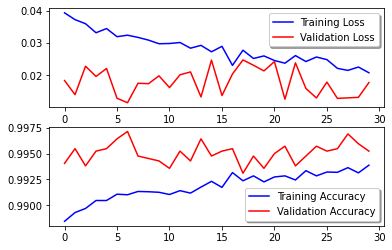

In [36]:
plt.figure(figsize=(16,22))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best',shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best',shadow=True)

### Confusion metrics

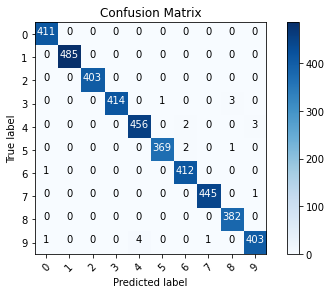

In [41]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = metrics.confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

### Predicting the test case

In [43]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [48]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)